# Hate Speech Detector 2.0
---
**Deep Learning vectorized text classifier** - GRU (Gated Recurrent Unit) NN

1. Load lemmatized tweets.
2. Load retrained (with own data) RoBERTa vectorizer.
3. Implement deep learning **GRU NN** model classifiers with appropriate dataset class. Adapt Deep Learning models to Classifier interface.
4. Perform multilabel classification task.
5. Visualize results by 7 different hate-speech labels plus 1 overall confusion matrices.
6. Perform some test on independent sanitized tweets about polish courts.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from src.classifiers.DLVectorClassifier import DLVectorClassifier
from src.vectorizers.WordPretrainedVectorizer import WordPretrainedVectorizer
from src.nn.models import GRUNet
from src.dataframes.utils import combine_row_wisely, shuffle_dataframe, class_weights
from src.visualization.classification import confusion_matrices, models_quality_plot, best_model_for_class
from src.constants import (LABELS, DUPLICATED_PATH, LEMMAS_PATH,
                           DLGRUC_CHART_DIR)

In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

In [3]:
WEIGHT_TYPE = 2

In [4]:
plt.style.use('ggplot')

## Data loading

### Classes

In [5]:
df_classes = pd.read_csv(DUPLICATED_PATH)[LABELS]
df_classes.head(2)

,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0


### Lemmatized tweets

In [6]:
df_lemmatized = pd.read_csv(LEMMAS_PATH).drop(['id'], axis=1)
df_lemmatized.head(2)

,lemmatized
0,w czwartek musieć poprawić sąd i trybunał
1,żale nałęcz i riposta macierewicz pan być w ko...


### Combined data

In [7]:
df_data = combine_row_wisely([df_lemmatized, df_classes])
df_data = shuffle_dataframe(df_data)
df_data.head(2)

,lemmatized,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
12411,od ocena prawny być prokuratura i sada nie ulica,0,0,0,0,0,0,0
6021,nie móc bezczynnie przyglądać się taki praktyk...,0,0,0,0,0,0,0


### Class weights

In [8]:
weights = class_weights(df_classes, w_type=WEIGHT_TYPE)
wlabel = f'w{WEIGHT_TYPE}'
weights

array([1.96630992, 1.95459439, 1.9713761 , 1.9734659 , 1.9341397 ,
       1.93059338, 1.99620037])

## Models implementation and testing

In [9]:
MODEL_KWARGS = [{'n_layers': 1, 'drop_prob': 0., 'bidirectional': False},
                {'n_layers': 3, 'drop_prob': 0., 'bidirectional': False},
                {'n_layers': 5, 'drop_prob': 0., 'bidirectional': False},
                {'n_layers': 1, 'drop_prob': 0.1, 'bidirectional': False},
                {'n_layers': 3, 'drop_prob': 0.1, 'bidirectional': False},
                {'n_layers': 5, 'drop_prob': 0.1, 'bidirectional': False},
                {'n_layers': 1, 'drop_prob': 0., 'bidirectional': True},
                {'n_layers': 3, 'drop_prob': 0., 'bidirectional': True},
                {'n_layers': 5, 'drop_prob': 0., 'bidirectional': True},
                {'n_layers': 1, 'drop_prob': 0.1, 'bidirectional': True},
                {'n_layers': 3, 'drop_prob': 0.1, 'bidirectional': True},
                {'n_layers': 5, 'drop_prob': 0.1, 'bidirectional': True},]
MODEL_LABELS = ['1-0-0', '3-0-0', '5-0-0', '1-1-0', '3-1-0', '5-1-0',
                '1-0-1', '3-0-1', '5-0-1', '1-1-1', '3-1-1', '5-1-1',]

In [10]:
X_data = df_data.drop(LABELS, axis=1).values
y_data = df_data[LABELS].values

y_preds = list([])

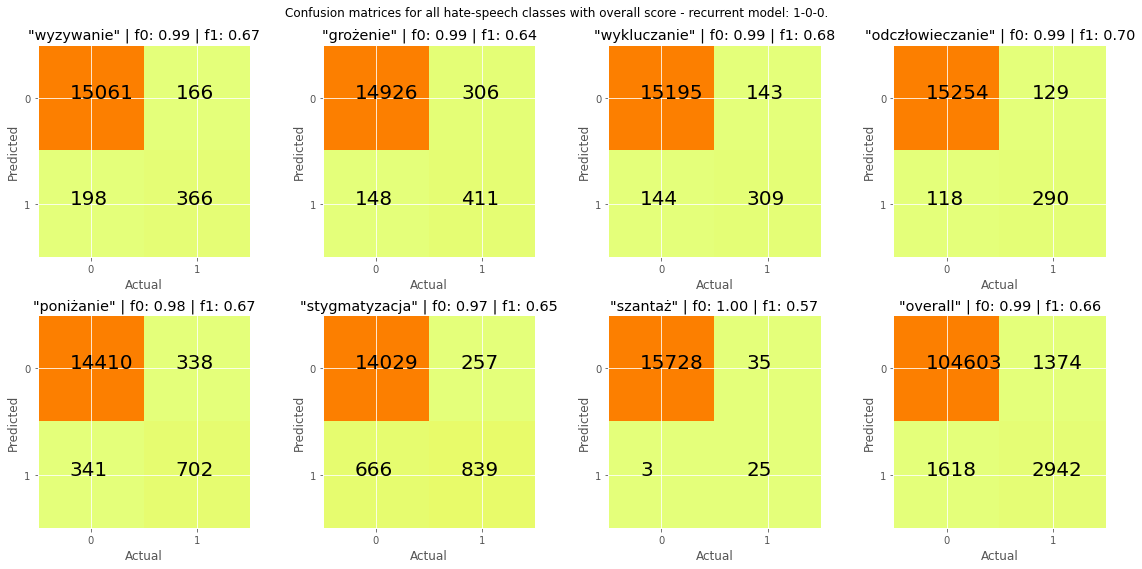

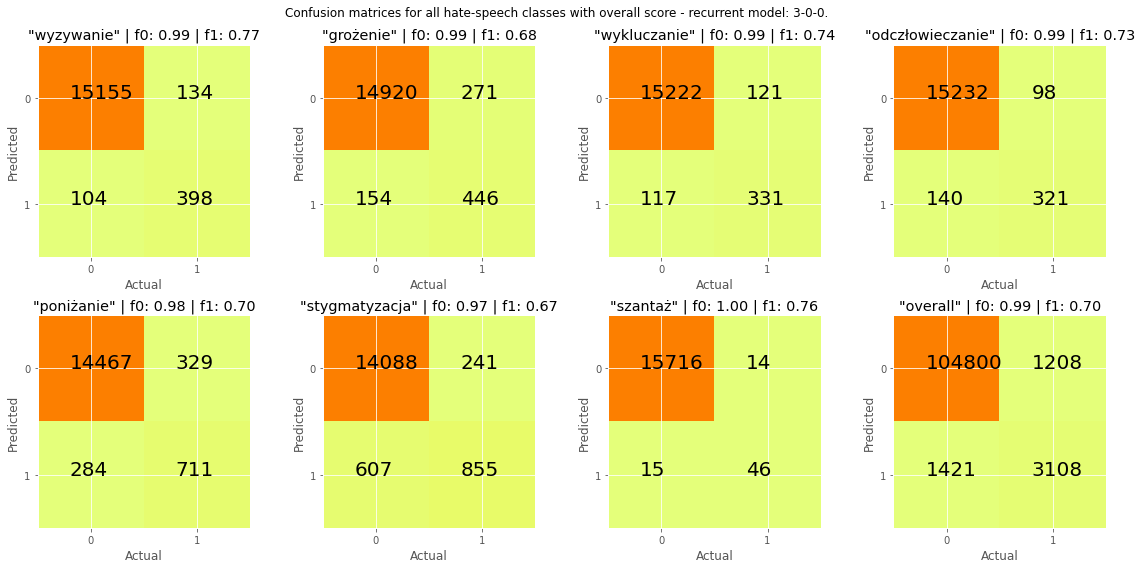

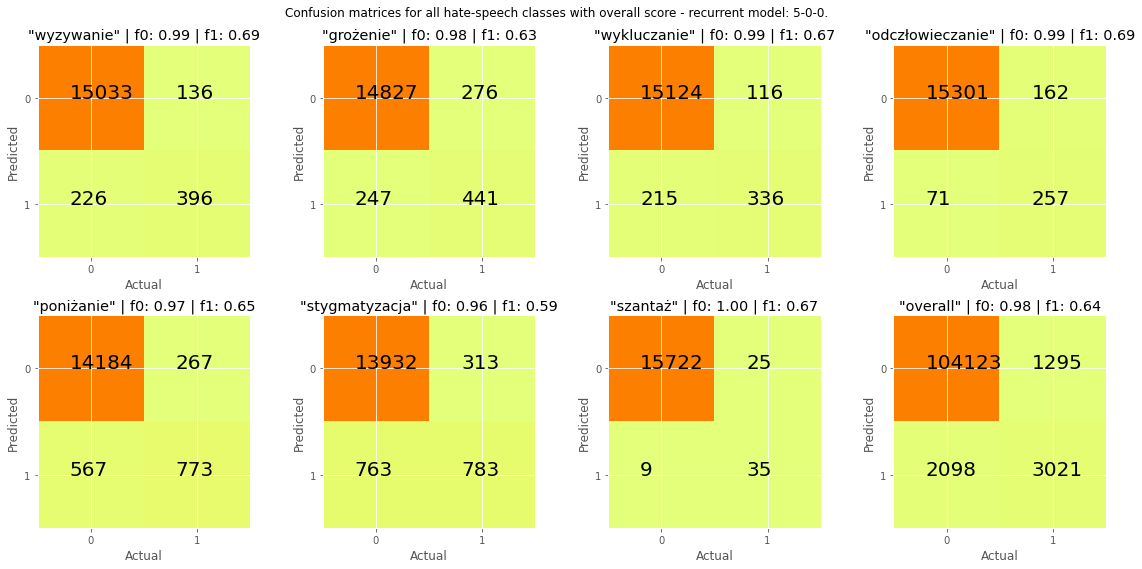

/home/jakub/Dokumenty/venv36/lib/python3.6/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


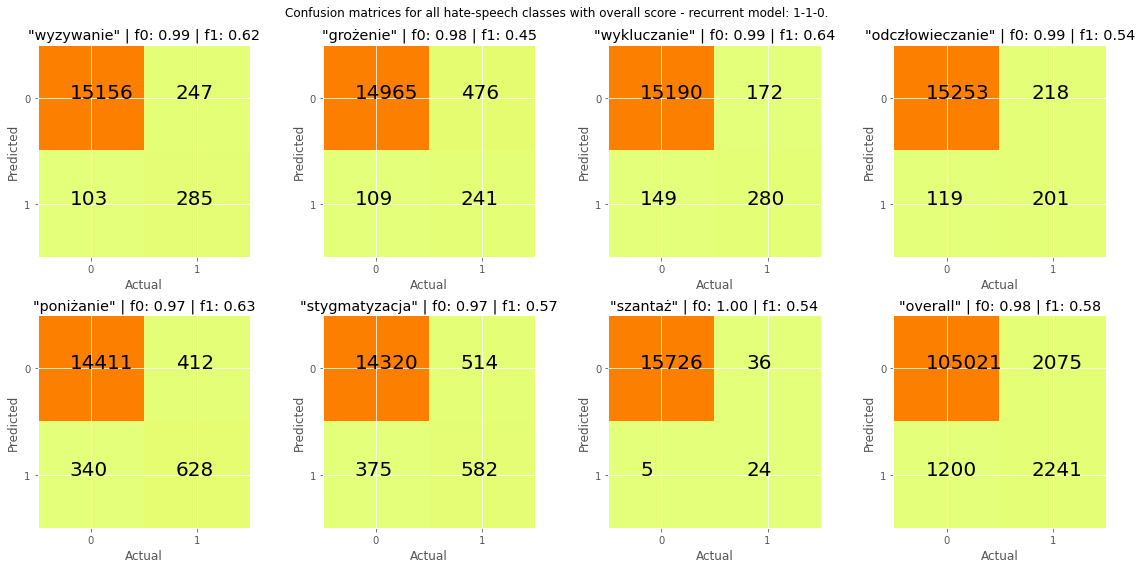

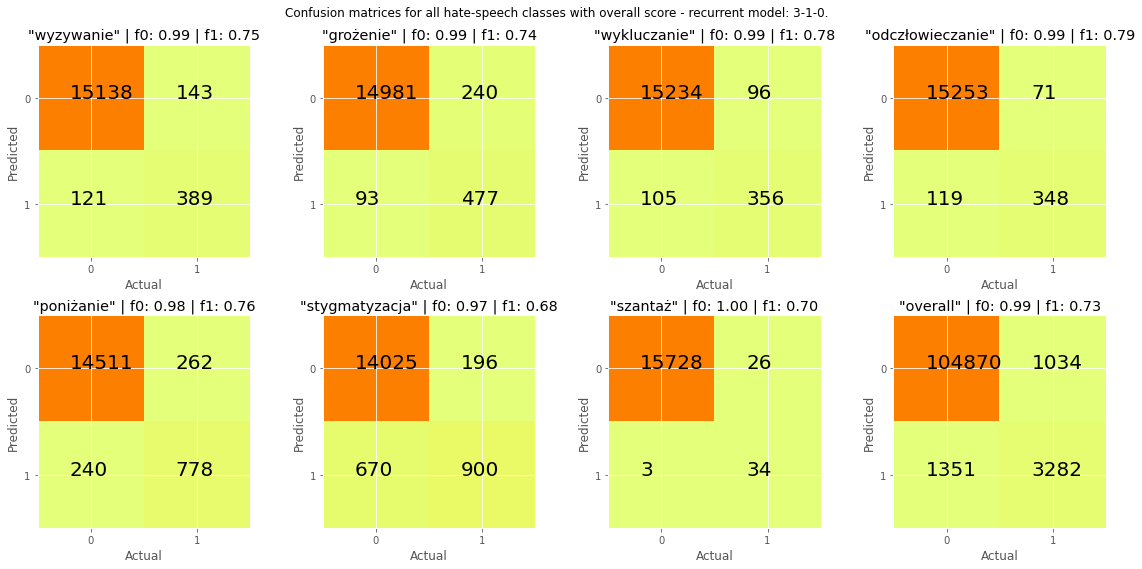

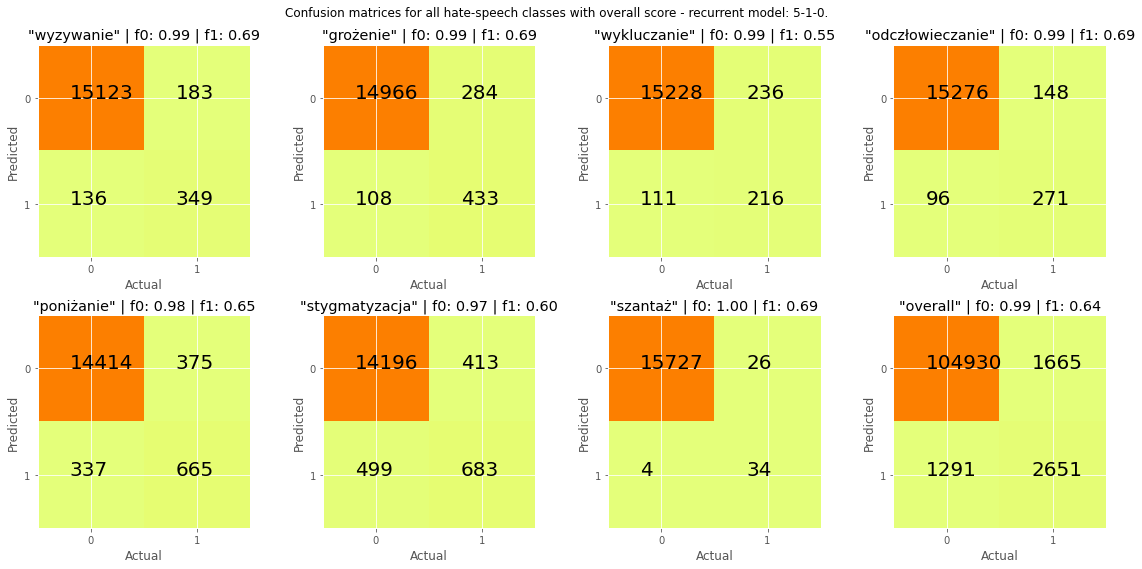

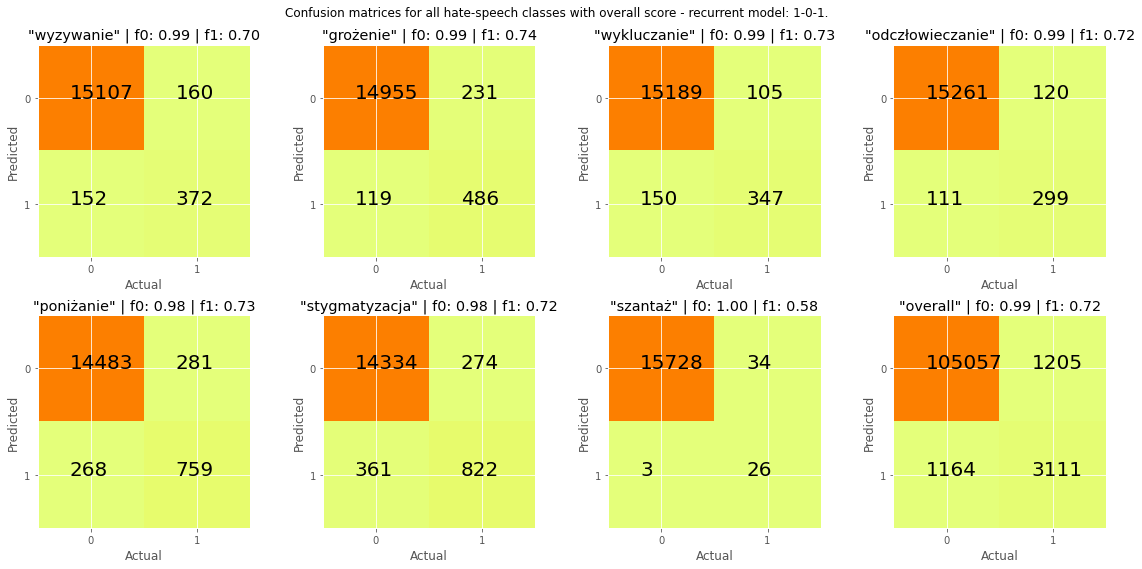

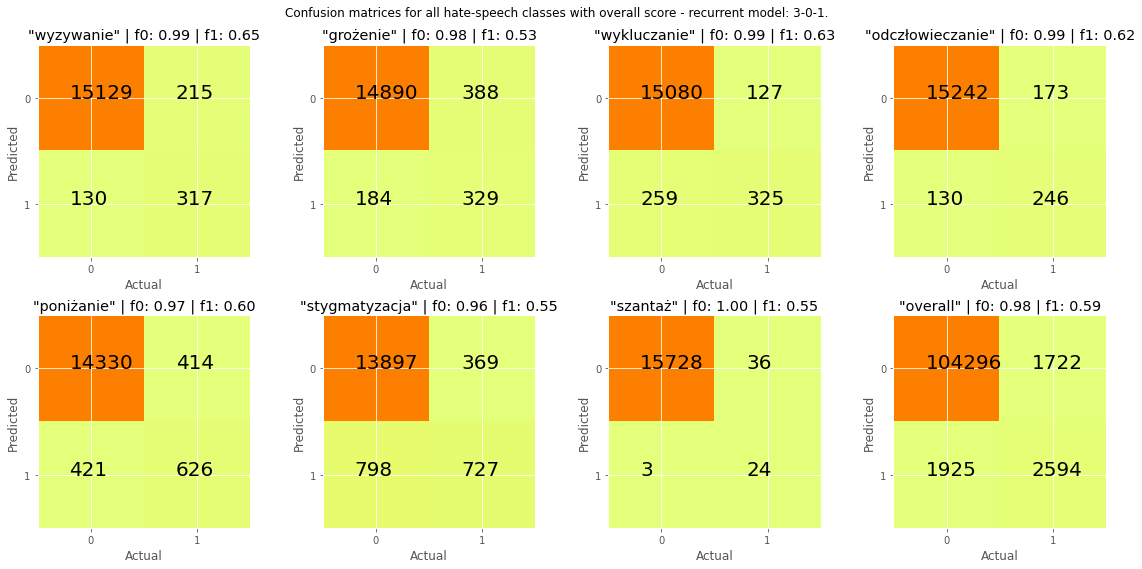

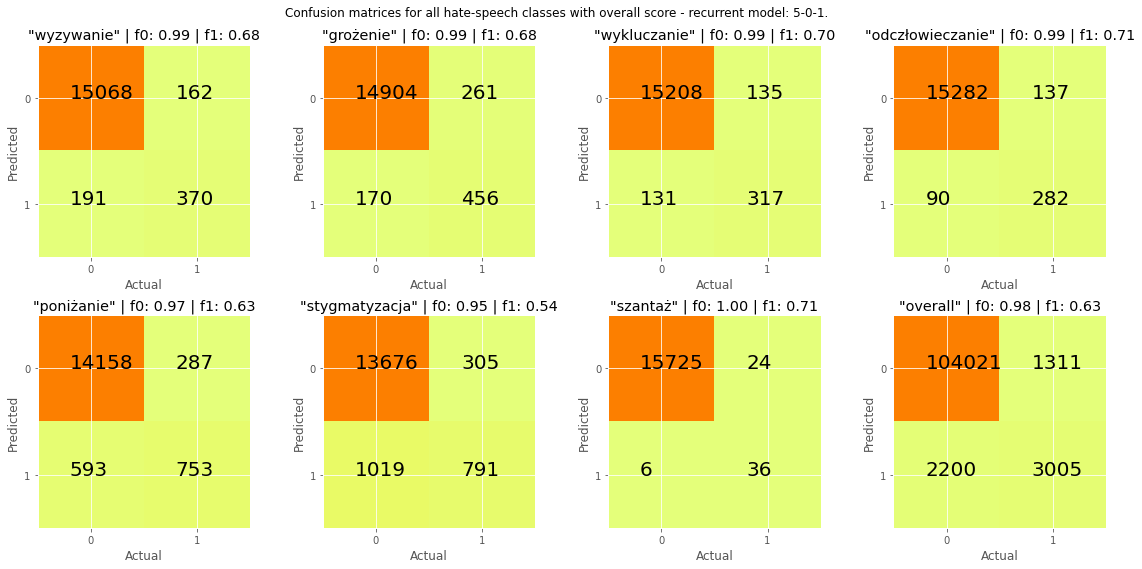

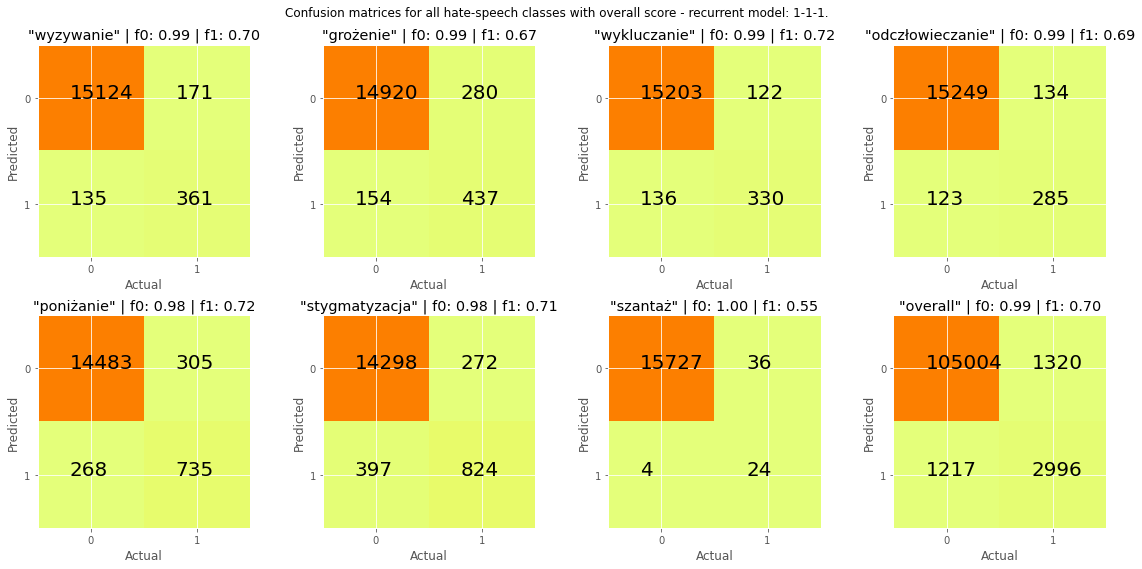

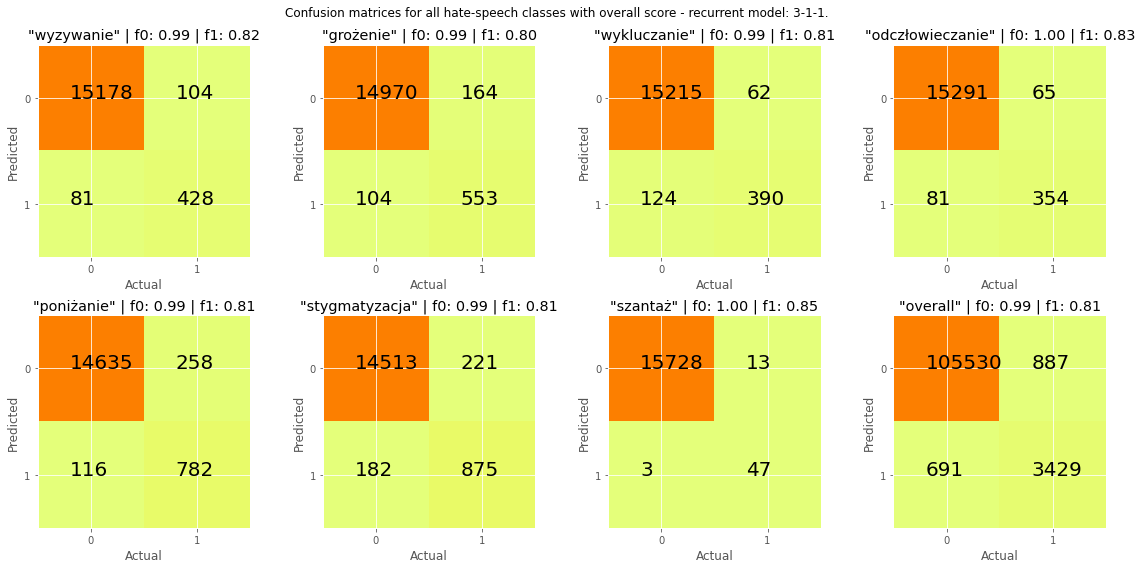

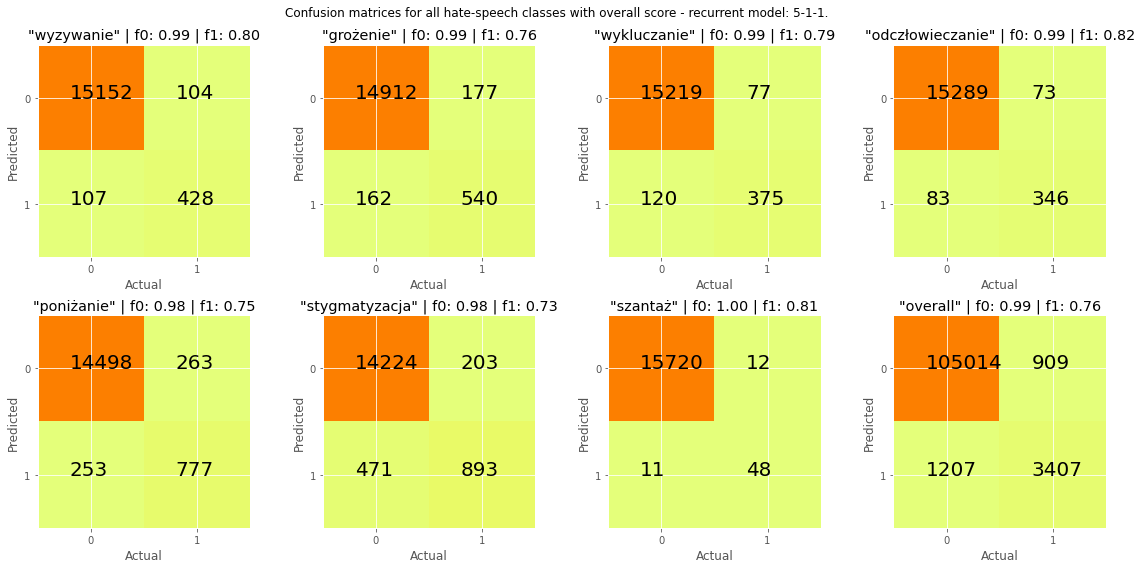

In [11]:
vkwargs = dict({'length': 50, 'model_type': 'cbow', 'short_name': 'CBoW'})
for mkwargs, mlabel in tqdm(zip(MODEL_KWARGS, MODEL_LABELS), total=len(MODEL_LABELS), leave=False):
    clf = DLVectorClassifier(short_name=mlabel, k_folds=5, weights=weights,
                             vec_class=WordPretrainedVectorizer, nn_class=GRUNet, nn_type=f'gru_{wlabel}',
                             vec_params=vkwargs, nn_params=mkwargs)
    
    clf.fit(X_data, y_data)
    # clf.load()
    clf.save()
    
    y_pred = clf.predict(X_data)
    confusion_matrices(y_data, y_pred,
                       title=f'Confusion matrices for all hate-speech classes with overall score - recurrent model: {mlabel}.',
                       save_file=DLGRUC_CHART_DIR.replace('{}', f'{wlabel}_confusion_matrices_{mlabel}'))
    y_preds.append(y_pred)
y_preds = np.array(y_preds)

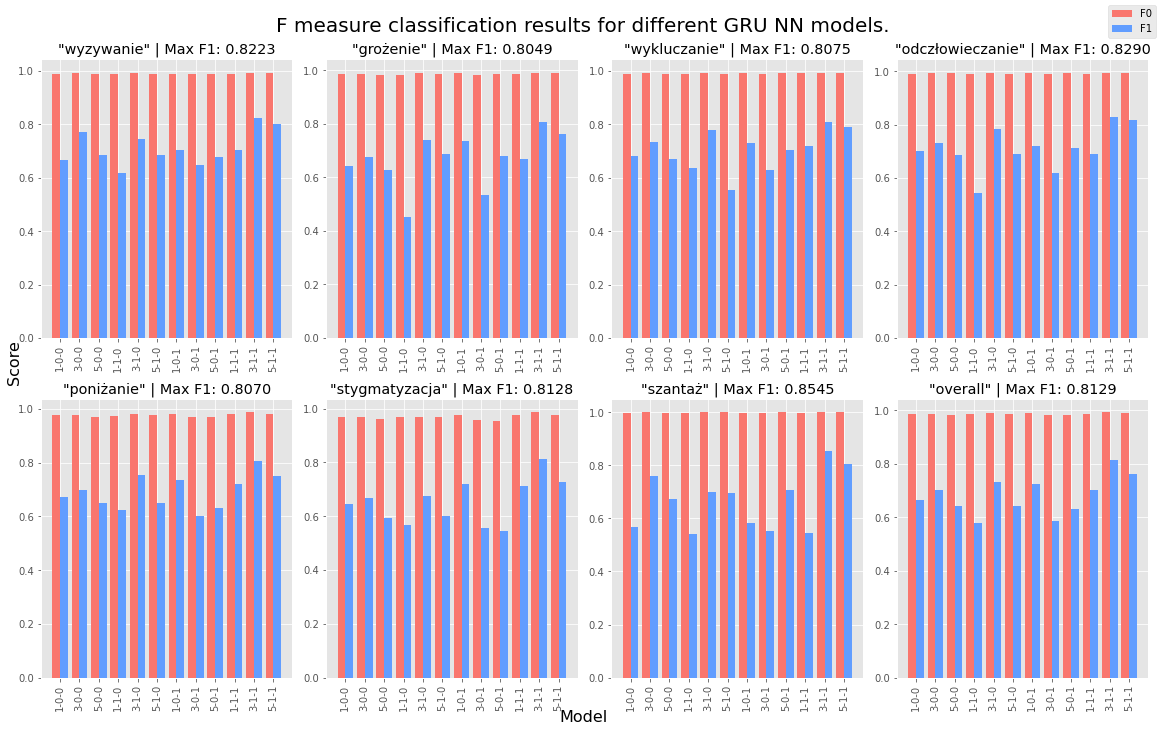

In [12]:
models_quality_plot(y_trues=y_data, y_preds_s=y_preds, model_names=MODEL_LABELS,
                    title='F measure classification results for different GRU NN models.',
                    measure='f', colors=['#f9766e', '#619dff'],
                    save_file=DLGRUC_CHART_DIR.replace('{}', f'{wlabel}_models_F_bars'))

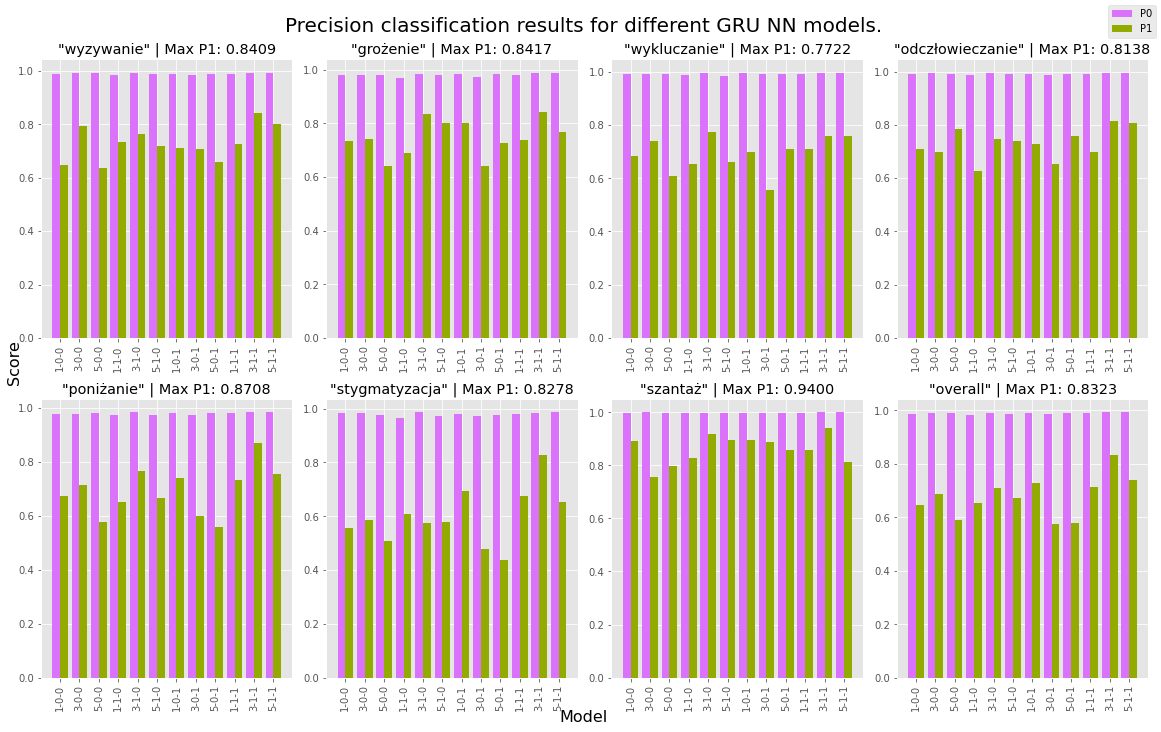

In [13]:
models_quality_plot(y_trues=y_data, y_preds_s=y_preds, model_names=MODEL_LABELS,
                    title='Precision classification results for different GRU NN models.',
                    measure='p', colors=['#da72fb', '#93aa00'],
                    save_file=DLGRUC_CHART_DIR.replace('{}', f'{wlabel}_models_P_bars'))

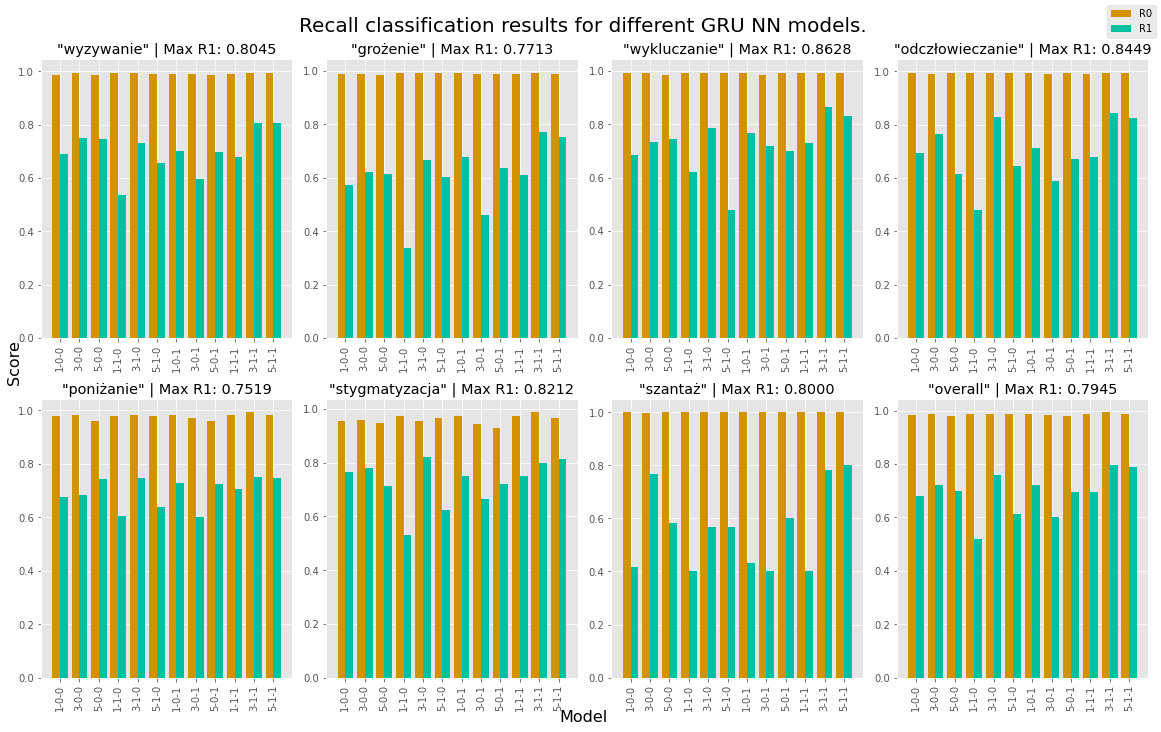

In [14]:
models_quality_plot(y_trues=y_data, y_preds_s=y_preds, model_names=MODEL_LABELS,
                    title='Recall classification results for different GRU NN models.',
                    measure='r', colors=['#d39200', '#00c19f'],
                    save_file=DLGRUC_CHART_DIR.replace('{}', f'{wlabel}_models_R_bars'))

## Best recurrent NN model

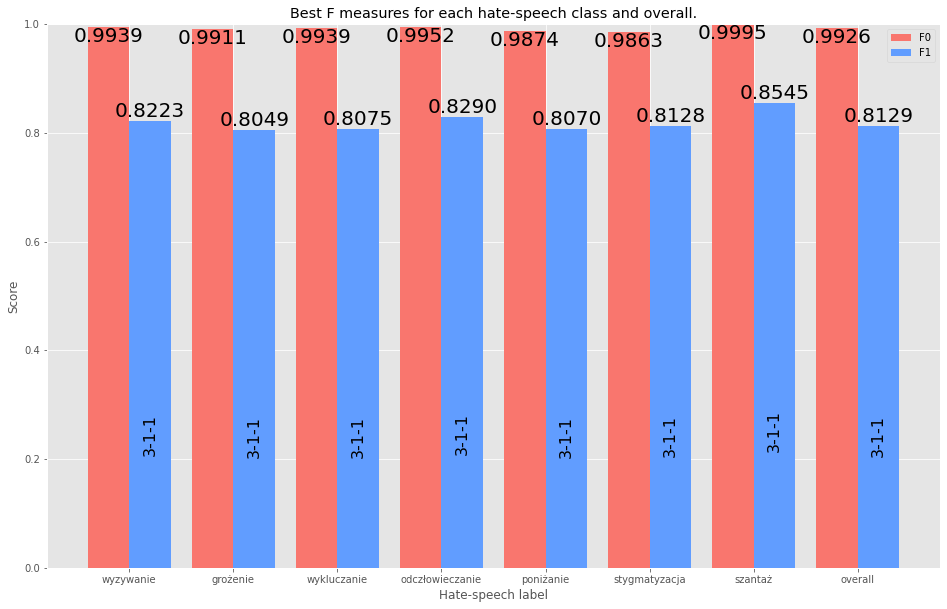

In [15]:
best_model_for_class(y_trues=y_data, y_preds_s=y_preds, model_names=MODEL_LABELS,
                     title='Best F measures for each hate-speech class and overall.',
                     save_file=DLGRUC_CHART_DIR.replace('{}', f'{wlabel}_best_F_bars'))

Judging by the above two analyses the best dense NN is that with **80 recurrent layers no dropout and no bidirectioning**.

In [16]:
vkwargs = dict({'length': 50, 'model_type': 'cbow', 'short_name': 'CBoW'})
mkwargs = dict({'n_layers': 5, 'drop_prob': 0.1, 'bidirectional': True})
clf = DLVectorClassifier(short_name='5-1-1', k_folds=5,
                         vec_class=WordPretrainedVectorizer, nn_class=GRUNet, nn_type=f'gru_{wlabel}',
                         vec_params=vkwargs, nn_params=mkwargs)
clf.load()

## Training history

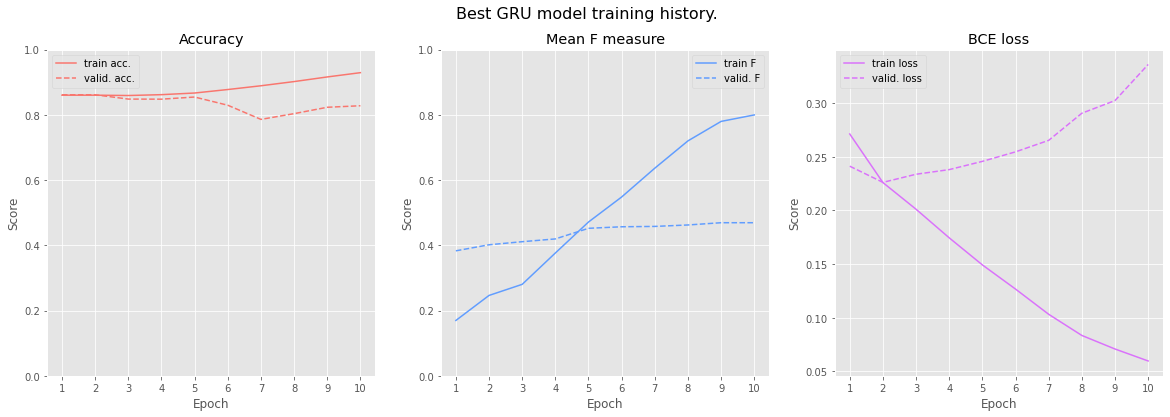

In [17]:
clf.plot_train_history_lines(title='Best GRU model training history.',
                             save_file=DLGRUC_CHART_DIR.replace('{}', f'{wlabel}_best_history_lines'))

## Tests

### Test 1

In [18]:
test_text1 = 'nie. po prostu skorumpowane zgniłe zatrute przez ciebie i twoich kolesiów sądy, które swoich zawsze wybronią'
preds1 = clf.test(test_text1)
dict(zip(LABELS, preds1))

{'wyzywanie': 0.0,
 'grożenie': 0.0,
 'wykluczanie': 0.0,
 'odczłowieczanie': 0.0,
 'poniżanie': 0.0,
 'stygmatyzacja': 0.0,
 'szantaż': 0.0}

Empirically should be: 'stygmatyzacja' as positive.

### Test 2

In [19]:
test_text2 = 'To nie sądy, to ludzie, sędziowie, zdrajcy barbarzyńcy w togach z mafijnej organizacji zdradziecko zbrodniczej którzy muszą zostać wyeliminowani'
preds2 = clf.test(test_text2)
dict(zip(LABELS, preds2))

{'wyzywanie': 0.0,
 'grożenie': 1.0,
 'wykluczanie': 0.0,
 'odczłowieczanie': 0.0,
 'poniżanie': 0.0,
 'stygmatyzacja': 0.0,
 'szantaż': 0.0}

Empirically labels: 'wyzywanie', 'grożenie', 'wykluczanie', 'poniżanie' and 'stygmatyzacja' should be positive.

### Test 3

In [20]:
test_text3 = 'Przed repolonizacją teren wyczyścić! Raz, dwa! Nie patrzeć na boki! Sądy sądami, ale media muszą być nasze media '
preds3 = clf.test(test_text3)
dict(zip(LABELS, preds3))

{'wyzywanie': 0.0,
 'grożenie': 0.0,
 'wykluczanie': 0.0,
 'odczłowieczanie': 0.0,
 'poniżanie': 0.0,
 'stygmatyzacja': 0.0,
 'szantaż': 0.0}

Empirically should be: 'grożenie' as positive.